In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    matthews_corrcoef,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    auc,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from dataclasses import dataclass
tqdm.pandas()
import matplotlib.pyplot as plt

2025-03-29 02:54:17.694637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-29 02:54:17.694789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-29 02:54:17.876149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 02:54:18.311868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-29 02:54:31.200330: W tensorflow/compiler/tf2

In [2]:
ROOT_DIR ='/data/user/home/mhossai5/DPP-New2025'

In [3]:
# Data & Model training arguments
SEED = 42
LR = 0.00001
BATCH_SIZE = 128
FEAT_NAME = [
    'CDKextended',
    'ECFP',
    'ECFP_512',
    'ECFP_2048',
]
MODEL_NAME = 'DNN'

TRAIN_HISTORY_PATH = os.path.join(ROOT_DIR, f'results/CDKExetended-ECFP-{MODEL_NAME}.csv')

In [4]:
import pandas as pd
import os

# Define the correct path
file_path = os.path.join(ROOT_DIR, "data/dpp4-26-03-25-feat.parquet")

# Read the Parquet file
df_final = pd.read_parquet(file_path)

In [5]:
X = np.concatenate([np.vstack(df_final[df_final['splits']=='train'][col]) for col in FEAT_NAME],axis = 1)
y = df_final[df_final['splits']=='train']['target']

X_test = np.concatenate([np.vstack(df_final[df_final['splits']=='test'][col]) for col in FEAT_NAME],axis = 1)
y_test = df_final[df_final['splits']=='test']['target']
X = np.nan_to_num(X)
X_test = np.nan_to_num(X_test)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.05,random_state = SEED,stratify=y)

In [6]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('X_val: ', X_val.shape)

X_train:  (4987, 4608)
X_test:  (1313, 4608)
X_val:  (263, 4608)


In [7]:
scaler = StandardScaler()

# Fit the scaler on the training data only
scaler.fit(X_train)

# Transform the train, validation, and test sets
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [8]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(BATCH_SIZE).shuffle(512,seed= SEED)
ds_val = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(BATCH_SIZE)

2025-03-29 02:55:00.301301: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 866 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0


In [9]:
# def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
#   inputs = x = keras.Input(shape = [input_size])
#   x = layers.Dense(input_size, activation='relu')(x)
#   x = layers.Dense(input_size//2, activation='relu')(x)
#   x = layers.Dense(num_classes, activation='softmax')(x)
#   return keras.Model(inputs=[inputs], outputs=x)


class MLP(tf.keras.Model):
    """Model that returns logits."""
    def __init__(self, n_classes, hidden_layer_sizes=(768,384,192)):
        super(MLP, self).__init__()
        self.denses = [tf.keras.layers.Dense(s, activation="relu") for s in hidden_layer_sizes]
        self.dense_class = tf.keras.layers.Dense(n_classes)
        self.dropout = tf.keras.layers.Dropout(0.25)

    def call(self, inputs, training=False):
        x = inputs
        for dense in self.denses:
            x = dense(x)
            x = self.dropout(x, training=training)
        return self.dense_class(x)

In [10]:
# Give your model a different name, as you have already used the variable name 'model'
classifier = MLP(2)
classifier.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
                   metrics=['accuracy'])

In [11]:
history = classifier.fit(ds_train,
                         validation_data=ds_val,
                         epochs=100,)

Epoch 1/100


2025-03-29 02:55:06.946958: I external/local_xla/xla/service/service.cc:168] XLA service 0x2aacba140ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-29 02:55:06.947004: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-03-29 02:55:06.959268: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-29 02:55:07.109359: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1743234907.279666   61992 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39/39 [==============================] - 5s 6ms/step - loss: 0.8385 - accuracy: 0.5629 - val_loss: 0.5276 - val_accuracy: 0.7605
Epoch 2/100
39/39 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6613 - val_loss: 0.4490 - val_accuracy: 0.8137
Epoch 3/100
39/39 [==============================] - 0s 3ms/step - loss: 0.5499 - accuracy: 0.7335 - val_loss: 0.3908 - val_accuracy: 0.8517
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 0.4787 - accuracy: 0.7804 - val_loss: 0.3517 - val_accuracy: 0.8783
Epoch 5/100
39/39 [==============================] - 0s 3ms/step - loss: 0.4380 - accuracy: 0.8055 - val_loss: 0.3177 - val_accuracy: 0.8783
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: 0.3909 - accuracy: 0.8314 - val_loss: 0.2941 - val_accuracy: 0.8859
Epoch 7/100
39/39 [==============================] - 0s 3ms/step - loss: 0.3546 - accuracy: 0.8564 - val_loss: 0.2713 - val_accuracy: 0.8935
Epoch 8/100
39/39 [======

In [12]:
# Model save weights
classifier.save(os.path.join(ROOT_DIR,f'weights/DPP4_{MODEL_NAME}_CDKExetended-ECFP_Weights.keras'))

## Evaluation:


In [13]:
y_pred_prob = tf.nn.softmax(classifier.predict(X_test)).numpy()
y_pred = y_pred_prob.argmax(-1)

42/42 [==============================] - 0s 3ms/step


In [14]:
np.savez(
    os.path.join(ROOT_DIR,'results',f'DPP4-{MODEL_NAME}-CDKExetended-ECFP-Preditions'),
    y_true = y_test,
    y_pred_prob = y_pred_prob,
    )

In [15]:
print(f"accuracy_score: {accuracy_score(y_test,y_pred)}")
print(f"roc_auc_score: {roc_auc_score(y_test,y_pred)}")
print(f"matthews_corrcoef: {matthews_corrcoef(y_test,y_pred)}")
print(f"F1 Score: {f1_score(y_test,y_pred,average='macro')}")

accuracy_score: 0.9695354150799695
roc_auc_score: 0.9691328990106054
matthews_corrcoef: 0.9385359779837497
F1 Score: 0.9692657007092531


In [16]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       717
           1       0.97      0.96      0.97       596

    accuracy                           0.97      1313
   macro avg       0.97      0.97      0.97      1313
weighted avg       0.97      0.97      0.97      1313



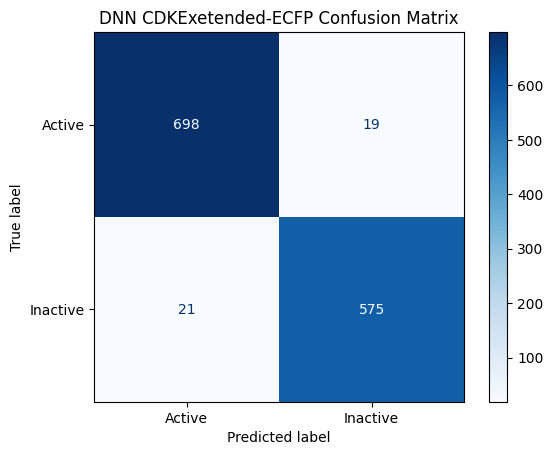

In [20]:
cm = confusion_matrix(y_test, y_pred)

# 6. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = ['Active', 'Inactive'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"DNN CDKExetended-ECFP Confusion Matrix")
plt.show()

## Metrics results & Plot

In [18]:
hist = history.history

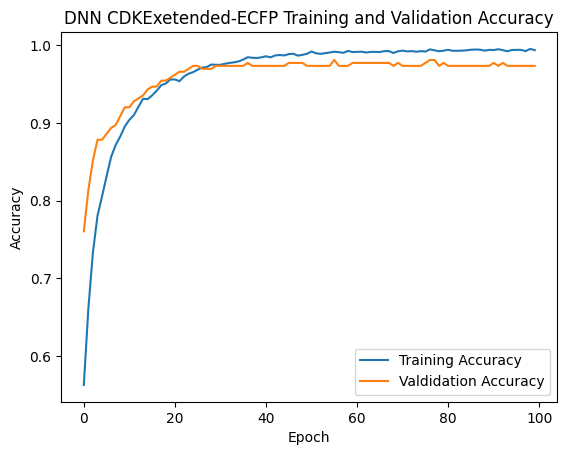

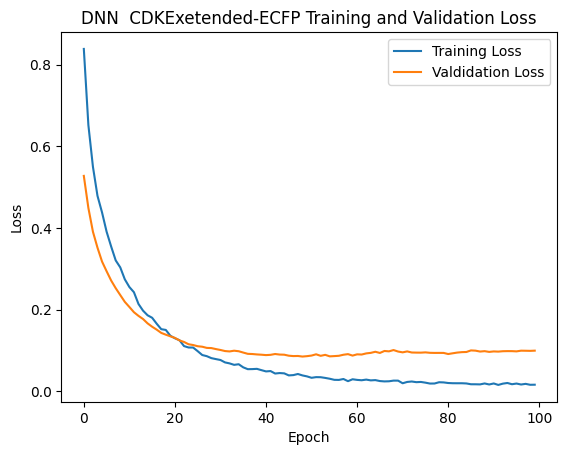

In [19]:
plt.title(f'{MODEL_NAME.upper()} CDKExetended-ECFP Training and Validation Accuracy')
plt.plot(hist['accuracy'],label= 'Training Accuracy')
plt.plot(hist['val_accuracy'],label= 'Valdidation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.title(f'{MODEL_NAME.upper()}  CDKExetended-ECFP Training and Validation Loss')
plt.plot(hist['loss'],label= 'Training Loss')
plt.plot(hist['val_loss'],label= 'Valdidation Loss')
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()